### Load modules 

In [1]:
import sys
sys.path.insert(1, '../utils')
from metrics import *

import numpy as np
import tqdm
from matplotlib import pyplot as plt
import matplotlib
from numpy.linalg import solve
import pybobyqa
import pandas as pd

matplotlib.style.use('seaborn')

### Load data

In [2]:
data = np.load('annual_global.npz')
temp = data['temp'] # temperature

In [3]:
data = np.load('../forcing.npz')
forcing = data['forcing']

year = forcing[:,0].astype('int')
forcing = forcing[:,1]

In [4]:
T, R = temp.shape

### Inference functions

In [5]:
def getK(phi):
    K = np.zeros((T,T))
    K[0,0] = 1
    for col in range(1,T):
        K[0,col] = phi * K[0,col-1]
    for row in range(1,T):
        K[row,row:] = K[row-1, row-1:-1]
    K = K + K.T
    K[range(T),range(T)] = 1

    return K

def getX(rho):
    X = np.ones((T,3))
    for t in range(T):
        _t = t+241 # _t is the index for year 2006 in forcing
        
        X[t,1] = forcing[_t] 

        X[t,2] = 0
        _coef = 1
        i = 1
        while _t-i > -1:
            X[t,2] += _coef * forcing[_t-i]
            _coef *= rho
            i += 1
        X[t,2] *= (1-rho)

    return X

In [6]:
def neg_llh(arg):
    rho, phi = arg
    value = np.log(1-phi*phi) * runsUsed * (T-1)
    
    # Build K
    K = getK(phi)
    
    # Build X
    X = getX(rho)
    
    Y = temp[:,:runsUsed]
    Kiy = np.linalg.solve(K, Y)

    part1 = np.sum(Y * Kiy, axis = 0)
    part2 = X.T @ Kiy
    part2 = np.sum(part2 * np.linalg.solve(X.T @ np.linalg.solve(K,X), part2), axis = 0)

    value += np.sum(T * np.log(part1-part2))
    return value

### Model inference

In [7]:
use_precomputed_results = True

In [8]:
if use_precomputed_results:
    results = pd.read_csv('results_model1.csv', index_col=0)
else:
    results = pd.DataFrame(columns = ['rho', 'beta0', 'beta1', 'beta2',
                                      'phi', 'sigmasq', 'Ifit', 'IUQ'])

    for runsUsed in tqdm.trange(1,R+1):
        res = pybobyqa.solve(neg_llh, x0 = [0.1, 0.9], 
                             bounds = ([0.01, -0.99], [0.99, 0.99])
                            )
            
        rho, phi = res.x

        # Build K
        K = getK(phi)

        # Build X
        X = getX(rho)

        beta = np.zeros(3)
        sigmasq = 0
        for r in range(runsUsed):
            _beta = solve(X.T @ solve(K, X), X.T @ solve(K, temp[:,r]))
            beta += _beta

            sigmasq += solve(K, temp[:,r] - X @ _beta) @ (temp[:,r] - X @ _beta) / T

        beta /= runsUsed
        sigmasq /= runsUsed

        results.loc[runsUsed] = [rho, *beta, phi, sigmasq, None, None]

        rho, beta0, beta1, beta2, phi, sigmasq, _, _ = results.loc[runsUsed]

        beta = np.array((beta0,beta1,beta2))

        K = getK(phi)
        X = getX(rho)

        mean = X @ beta

        residual = np.zeros((T, R))

        for r in range(R):
            residual[0,r] = np.random.normal(0, np.sqrt(sigmasq*(1-phi*phi)))
            for t in range(1,T):
                residual[t,r] = phi * residual[t-1,r] + np.random.normal(0, np.sqrt(sigmasq*(1-phi*phi)))

        hatY = (mean + residual.T).T

        results.loc[runsUsed]['Ifit'] = get_I_fit(mean, temp)
        results.loc[runsUsed]['IUQ'] = get_I_UQ((mean + residual.T).T, temp)
        
    results.to_csv('results_model1.csv')

## Report

#### Model infernce using 6 model runs

In [9]:
runsUsed = 6
res = pybobyqa.solve(neg_llh, x0 = [0.1, 0.9], 
                     bounds = ([0.01, -0.99], [0.99, 0.99])
                    )

rho, phi = res.x

# Build K
K = getK(phi)

# Build X
X = getX(rho)

beta = np.zeros(3)
sigmasq = 0
for r in range(runsUsed):
    _beta = solve(X.T @ solve(K, X), X.T @ solve(K, temp[:,r]))
    beta += _beta

    sigmasq += solve(K, temp[:,r] - X @ _beta) @ (temp[:,r] - X @ _beta) / T

beta /= runsUsed
sigmasq /= runsUsed

#### Simulate 35 realizations

In [10]:
mean = X @ beta
residual = np.zeros((T, R))

for r in range(R):
    residual[0,r] = np.random.normal(0, np.sqrt(sigmasq*(1-phi*phi)))
    for t in range(1,T):
        residual[t,r] = phi * residual[t-1,r] + np.random.normal(0, np.sqrt(sigmasq*(1-phi*phi)))

hatY = (mean + residual.T).T

#### Plot

In [11]:
TmeanStart = temp[0].mean()

In [12]:
results=results.loc[1:20]

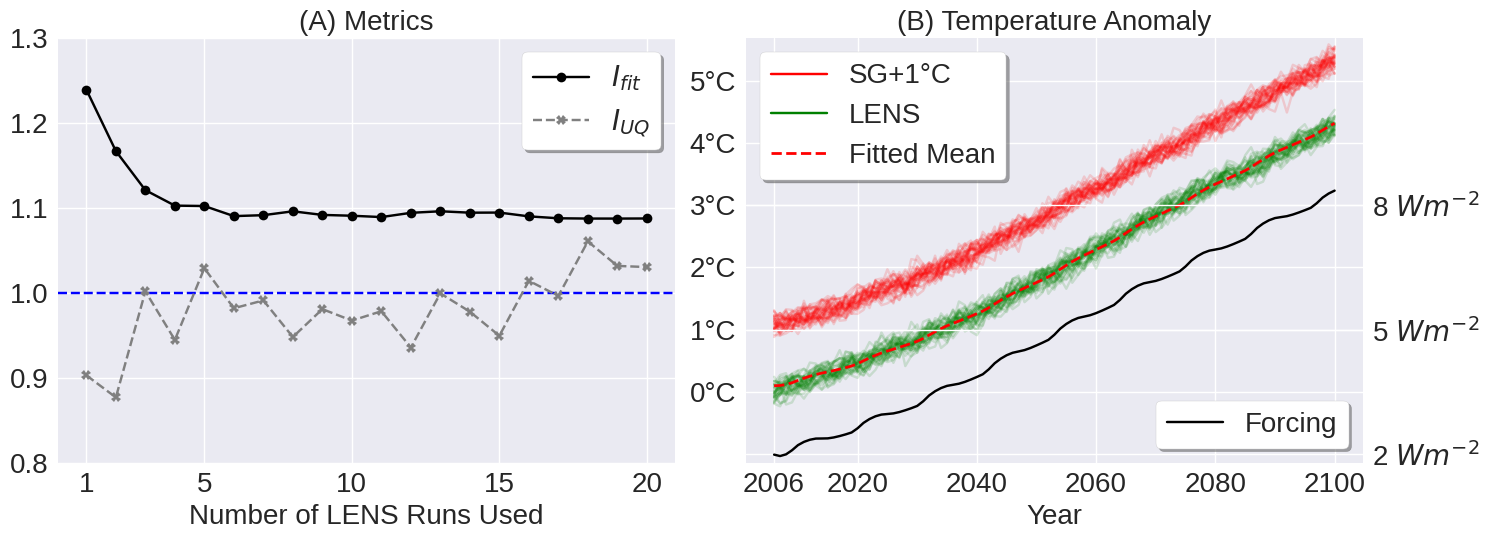

In [13]:
matplotlib.style.use('seaborn')
plt.figure(figsize = (15,5.5))

plt.subplot(121)
plt.title('(A) Metrics',fontsize = 20)

plt.plot(results['Ifit'], 'ko-', label = '$I_{fit}$')
plt.xlabel('Number of LENS Runs Used', fontsize = 20)
plt.xticks([1, *np.arange(5,45,5)], fontsize = 20)
plt.yticks(fontsize = 20)
plt.axhline(1, color = 'blue', linestyle = '--')

plt.plot(results['IUQ'], label = '$I_{UQ}$', 
         marker = 'X', color = 'gray', linestyle='dashed')
plt.ylim(0.8,1.3)
plt.legend(fontsize = 20, frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True)

ax = plt.subplot(122)
plt.plot(range(2006,2101),hatY[:,0]+1-TmeanStart, color = 'red', label = 'SG+1\u00B0C', alpha = 0.15);

plt.plot(range(2006,2101), temp[:,0]-TmeanStart, color = 'green', label = 'LENS', alpha = 0.15);
plt.plot(range(2006,2101), temp[:,1:]-TmeanStart, color = 'green', alpha = 0.15);

plt.plot(range(2006,2101),hatY[:,1:]+1-TmeanStart, color = 'red', alpha = 0.15);

plt.plot(range(2006,2101),mean-TmeanStart,'r--', label = 'Fitted Mean', linewidth = 2)

plt.title('(B) Temperature Anomaly',fontsize = 20)

plt.xticks([2006,*range(2020,2101,20)], fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.yticks(range(7), [u'{}\u00B0C'.format(x) for x in range(7)], fontsize = 20)

leg = plt.legend(fontsize = 20, frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.ylim(-1-0.14,6-0.32)

ax_ = ax.twinx()
plt.plot(range(2006,2101), forcing[241:241+T], label = 'Forcing', color = 'black')
plt.yticks(range(2,9,3), ['%d $Wm^{-2}$' % x for x in range(2,9,3)], fontsize = 20)
plt.legend(fontsize = 20, loc = 'lower right', frameon = True, facecolor = 'white', 
                 shadow = True, fancybox = True)
plt.ylim(2-0.2,12)



plt.tight_layout()

plt.savefig('F3-global.pdf')

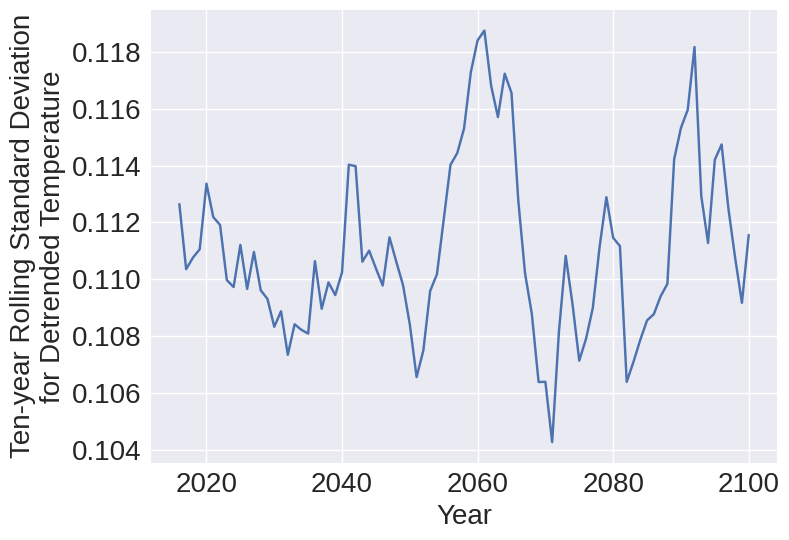

In [14]:
detrended = temp.T-mean
rolling_annual_std = np.array([np.std(detrended[:,i:i+10]) for i in range(0, detrended.shape[1]-10)])

plt.plot(range(2016,2101), rolling_annual_std)
plt.xlabel('Year', fontsize = 20)
plt.ylabel('Ten-year Rolling Standard Deviation\nfor Detrended Temperature', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.tight_layout()
plt.savefig('SF2-10y-rolling-std-global-annual.pdf')